In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from datetime import datetime
import time
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
df = pd.read_csv('/content/drive/MyDrive/SocialMediaUsersDataset.csv')
df.head()

,UserID,Name,Gender,DOB,Interests,City,Country
0,1,Jesse Lawhorn,Female,1958-10-15,"'Movies', 'Fashion', 'Fashion', 'Books'",Sibolga,Indonesia
1,2,Stacy Payne,Female,2004-07-21,"'Gaming', 'Finance and investments', 'Outdoor ...",Al Abyār,Libya
2,3,Katrina Nicewander,Female,2000-02-07,"'DIY and crafts', 'Music', 'Science', 'Fashion'",Wādī as Sīr,Jordan
3,4,Eric Yarbrough,Male,1985-04-14,"'Outdoor activities', 'Cars and automobiles'",Matera,Italy
4,5,Daniel Adkins,Female,1955-09-18,"'Politics', 'History'",Biruaca,Venezuela


In [3]:
df.columns

Index(['UserID', 'Name', 'Gender', 'DOB', 'Interests', 'City', 'Country'], dtype='object')

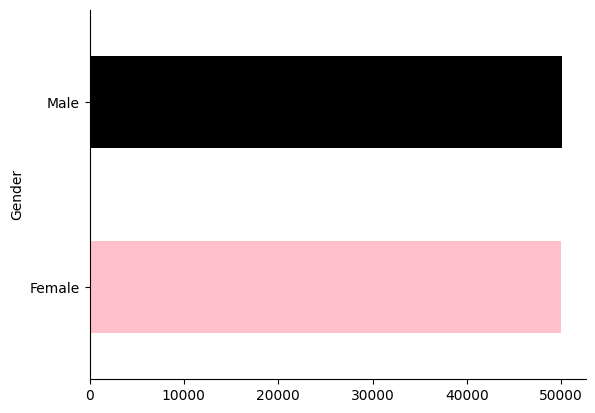

In [4]:
# Define colors for each gender category
colors = {'Male': 'black', 'Female': 'pink'}

# Plot the bar chart with specified colors
df.groupby('Gender').size().plot(kind='barh', color=[colors[gender] for gender in df['Gender'].unique()])

# Remove the top and right spines for a cleaner look
plt.gca().spines[['top', 'right']].set_visible(False)

# Display the plot
plt.show()

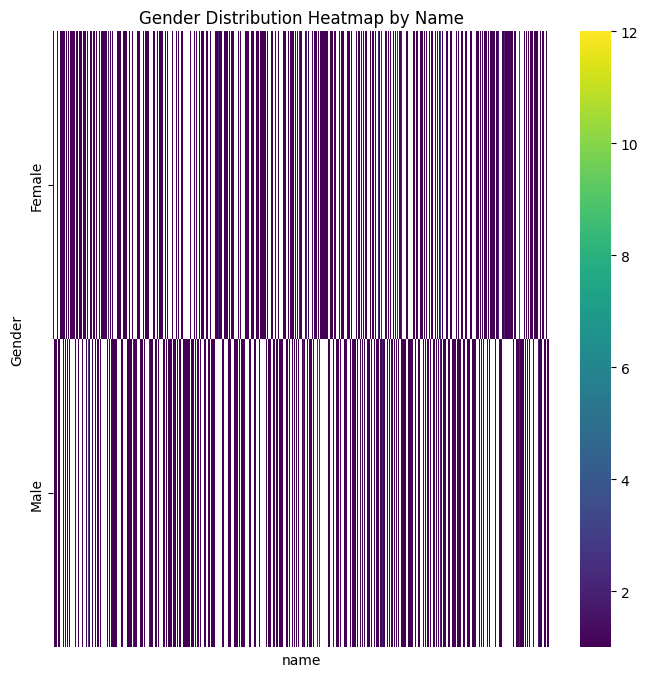

In [5]:
# Create the 2D histogram DataFrame for plotting
df_2dhist = pd.DataFrame({
    x_label: grp['Gender'].value_counts()
    for x_label, grp in df.groupby('Name')
})

# Plot the heatmap
plt.subplots(figsize=(8, 8))
sns.heatmap(df_2dhist, cmap='viridis', cbar=True)

# Remove x-axis labels (name labels)
plt.xlabel('name')
plt.xticks([])  # Removes x-axis labels completely

# Add y-axis label
plt.ylabel('Gender')
plt.title('Gender Distribution Heatmap by Name')
plt.show()


In [6]:
df.fillna("", inplace=True)
df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')
df['Age'] = datetime.now().year - df['DOB'].dt.year
df['Age'] = df['Age'].fillna(0).astype(int)
df['InterestCount'] = df['Interests'].apply(lambda x: len(set(x.replace("'", "").split(", "))))
encoder = LabelEncoder()
df['CityEncoded'] = encoder.fit_transform(df['City'])
df['CountryEncoded'] = encoder.fit_transform(df['Country'])

In [7]:
for column in df.columns:
   if df[column].dtype == 'float64' or df[column].dtype == 'int64':
       column_mean = df[column].mean()
       df[column].fillna(column_mean, inplace=True)
df.head()


<ipython-input-7-31c0cace9d51>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(column_mean, inplace=True)


,UserID,Name,Gender,DOB,Interests,City,Country,Age,InterestCount,CityEncoded,CountryEncoded
0,1,Jesse Lawhorn,Female,1958-10-15,"'Movies', 'Fashion', 'Fashion', 'Books'",Sibolga,Indonesia,67,3,19581,98
1,2,Stacy Payne,Female,2004-07-21,"'Gaming', 'Finance and investments', 'Outdoor ...",Al Abyār,Libya,21,4,314,121
2,3,Katrina Nicewander,Female,2000-02-07,"'DIY and crafts', 'Music', 'Science', 'Fashion'",Wādī as Sīr,Jordan,25,4,23293,109
3,4,Eric Yarbrough,Male,1985-04-14,"'Outdoor activities', 'Cars and automobiles'",Matera,Italy,40,2,13141,104
4,5,Daniel Adkins,Female,1955-09-18,"'Politics', 'History'",Biruaca,Venezuela,70,2,2646,237


In [9]:
G = nx.Graph()
for idx, row in df.iterrows():
    interests = row['Interests'].replace("'", "").split(", ")
    for interest in interests:
        G.add_edge(row['UserID'], interest)

sampled_nodes = list(G.nodes)
G = G.subgraph(sampled_nodes)
print(f"Graph reduced to {len(G.nodes)} nodes and {len(G.edges)} edges.")

Graph reduced to 100029 nodes and 285631 edges.


In [10]:
start_time = time.time()
pagerank = nx.pagerank(G)
print(f"PageRank calculated in {time.time() - start_time:.2f} seconds.")
df['PageRank'] = df['UserID'].apply(lambda x: pagerank.get(x, 0))
# Normalize data set features
scaler = MinMaxScaler()
df[['PageRank', 'InterestCount', 'Age']] = scaler.fit_transform(df[['PageRank', 'InterestCount', 'Age']])
print("Features normalized.")

PageRank calculated in 2.39 seconds.
Features normalized.


In [11]:
df['DOB'] = pd.to_datetime(df['DOB'])
df['Year_of_Birth'] = df['DOB'].dt.year
current_year = pd.to_datetime('today').year
df['Age'] = current_year - df['Year_of_Birth']

In [12]:
df['Interests'] = df['Interests'].apply(lambda x: x.strip("'").split("', '"))
df.head()

,UserID,Name,Gender,DOB,Interests,City,Country,Age,InterestCount,CityEncoded,CountryEncoded,PageRank,Year_of_Birth
0,1,Jesse Lawhorn,Female,1958-10-15,"[Movies, Fashion, Fashion, Books]",Sibolga,Indonesia,67,0.50,19581,98,0.499792,1958
1,2,Stacy Payne,Female,2004-07-21,"[Gaming, Finance and investments, Outdoor acti...",Al Abyār,Libya,21,0.75,314,121,0.746722,2004
2,3,Katrina Nicewander,Female,2000-02-07,"[DIY and crafts, Music, Science, Fashion]",Wādī as Sīr,Jordan,25,0.75,23293,109,0.747942,2000
3,4,Eric Yarbrough,Male,1985-04-14,"[Outdoor activities, Cars and automobiles]",Matera,Italy,40,0.25,13141,104,0.249251,1985
4,5,Daniel Adkins,Female,1955-09-18,"[Politics, History]",Biruaca,Venezuela,70,0.25,2646,237,0.249715,1955


In [13]:
def count_interests(interests_list):
   interests = {}
   for sublist in interests_list:
       for interest in sublist:
           if interest in interests:
               interests[interest] += 1
           else:
               interests[interest] = 1
   return interests

interest_counts = count_interests(df['Interests'])

<ipython-input-14-45a267add220>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


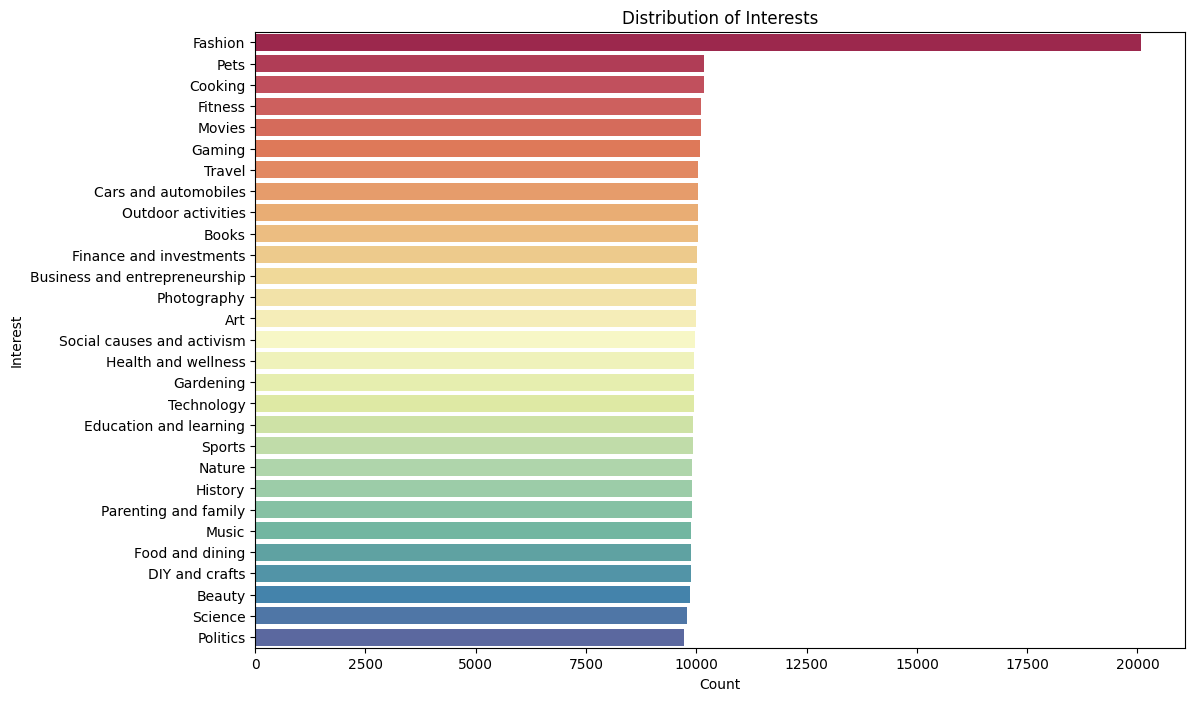

In [14]:
# Create a DataFrame from interest counts
interest_df = pd.DataFrame(list(interest_counts.items()), columns=['Interest', 'Count'])

# Set the figure size for better readability
plt.figure(figsize=(12, 8))

# Use a vibrant color palette like 'Spectral' for the bar plot
sns.barplot(
    data=interest_df.sort_values(by='Count', ascending=False),
    x='Count',
    y='Interest',
    palette='Spectral'  # Try 'coolwarm', 'Blues', or 'Spectral' for a visually appealing result
)

# Add titles and labels
plt.title('Distribution of Interests')
plt.xlabel('Count')
plt.ylabel('Interest')

# Show the plot
plt.show()

<ipython-input-15-a537c8649852>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Gender', palette='coolwarm')


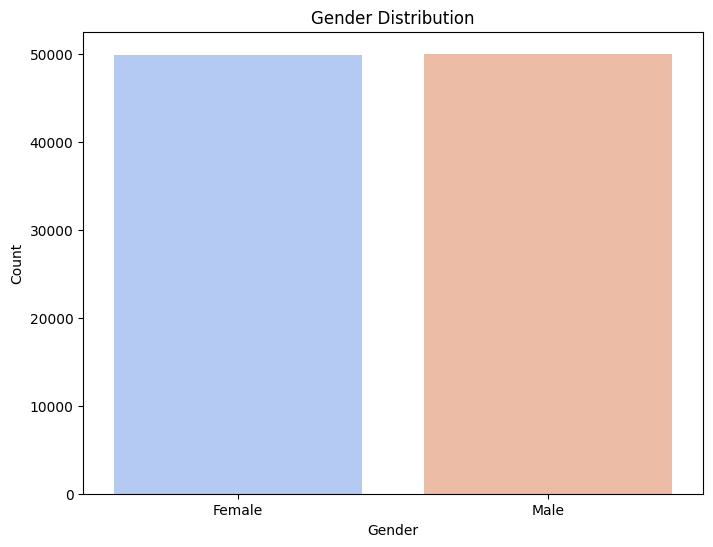

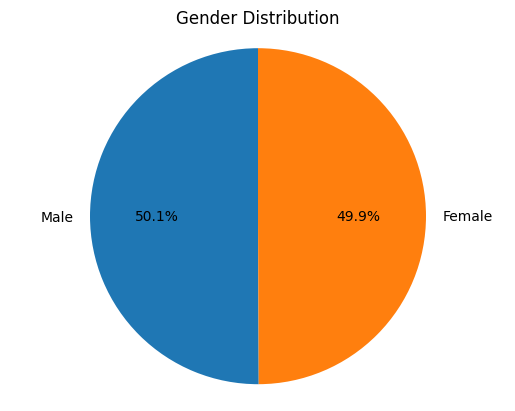

In [15]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Gender', palette='coolwarm')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

gender_counts = df['Gender'].value_counts()
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
_ = plt.title('Gender Distribution')

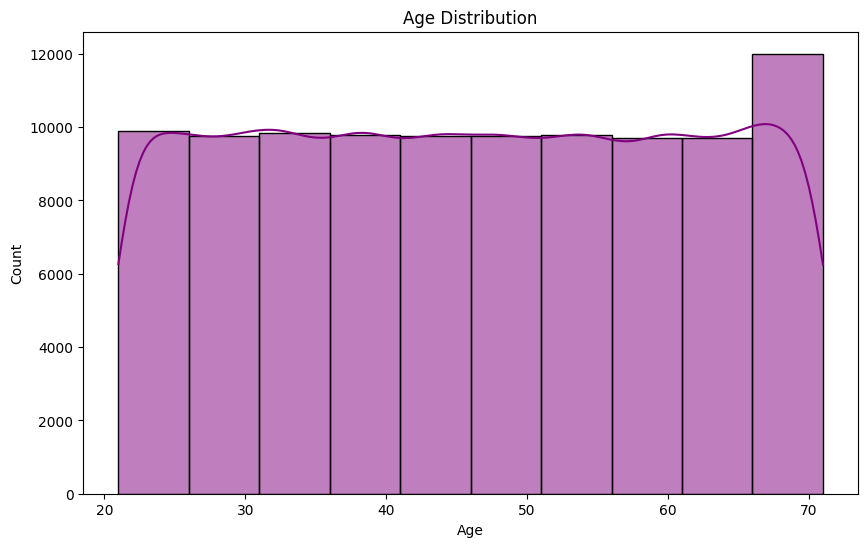

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', bins=10, kde=True, color='purple')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [17]:
def recommend_strategies(df):
   gender_dist = df['Gender'].value_counts(normalize=True) * 100
   interest_dist = interest_df.sort_values(by='Count', ascending=False)

   print("Recommendations based on gender distribution:")
   if gender_dist['Female'] > 50:
       print("- Focus on products and services that cater to female interests.")
   if gender_dist['Male'] > 50:
       print("- Focus on products and services that cater to male interests.")

   print("\nTop 3 interests to focus marketing campaigns on:")
   for i, row in interest_dist.head(3).iterrows():
       print(f"- {row['Interest']}")

   age_dist = df['Age'].describe()
   print("\nAge-related recommendations:")
   if age_dist['mean'] < 30:
       print("- Focus on trendy and youthful products.")
   if age_dist['mean'] > 40:
       print("- Focus on products that cater to mature consumers.")

   print("\nRegional recommendations:")
   print(df['Country'].value_counts().head(3))


In [18]:
recommend_strategies(df)

Recommendations based on gender distribution:
- Focus on products and services that cater to male interests.

Top 3 interests to focus marketing campaigns on:
- Fashion
- Pets
- Cooking

Age-related recommendations:
- Focus on products that cater to mature consumers.

Regional recommendations:
Country
United States    12311
India             9399
China             7381
Name: count, dtype: int64


In [19]:
X = df[['PageRank', 'InterestCount', 'Age', 'CityEncoded', 'CountryEncoded']].values
y = (df['PageRank'] > 0.5).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
}


In [21]:
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    results[name] = {
        "F1 Score": f1,
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
    }
    print(f"{name} - F1 Score: {f1:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(classification_report(y_test, y_pred))

Training RandomForest...
RandomForest - F1 Score: 1.0000
Train Accuracy: 1.0000, Test Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12390
           1       1.00      1.00      1.00      7610

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

Training XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:05:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - F1 Score: 1.0000
Train Accuracy: 1.0000, Test Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12390
           1       1.00      1.00      1.00      7610

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

Training LightGBM...
[LightGBM] [Info] Number of positive: 30142, number of negative: 49858
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 790
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376775 -> initscore=-0.503259
[LightGBM] [Info] Start training from score -0.503259
[LightGBM] [Warning] No

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM - F1 Score: 0.9976
Train Accuracy: 0.9997, Test Accuracy: 0.9981
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12390
           1       1.00      1.00      1.00      7610

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [22]:
best_model_name = max(results, key=lambda x: results[x]["F1 Score"])
best_model = models[best_model_name]
print(f"Best Model: {best_model_name} with F1 Score: {results[best_model_name]['F1 Score']:.4f}")
print(f"Train Accuracy: {results[best_model_name]['Train Accuracy']:.4f}")
print(f"Test Accuracy: {results[best_model_name]['Test Accuracy']:.4f}")

Best Model: RandomForest with F1 Score: 1.0000
Train Accuracy: 1.0000
Test Accuracy: 1.0000


In [23]:
print("Saving the best model")
with open(f"best_friend_recommendation_model_{best_model_name}.pkl", "wb") as f:
    pickle.dump(best_model, f)
print(f"Model saved as best_friend_recommendation_model_{best_model_name}.pkl")

Saving the best model
Model saved as best_friend_recommendation_model_RandomForest.pkl


In [24]:
def recommend_friends(user_index, top_n=3):
    user = df.iloc[user_index]
    user_pagerank = user['PageRank']
    user_country = user['Country']
    similar_users = df[
        (df['PageRank'] > user_pagerank)
        & (df['CountryEncoded'] == user['CountryEncoded'])
    ].sort_values('PageRank', ascending=False)[:top_n]

    recommendations = similar_users[['UserID', 'Name', 'Gender', 'DOB', 'Interests', 'City', 'Country']]

    print(f"Recommendations for User {user['Name']} (UserID: {user['UserID']}):")
    for _, row in recommendations.iterrows():
        print(f"UserID {row['UserID']} ({row['Name']})")

    return recommendations

In [25]:
print("Friends recommendations on Meta Platforms")
recommendations = recommend_friends(0)
print(recommendations)

Friends recommendations on Meta Platforms
Recommendations for User Jesse Lawhorn (UserID: 1):
UserID 32047 (Joseph Harju)
UserID 17277 (Juan Johnson)
UserID 24650 (Edith Weir)
       UserID          Name  Gender        DOB  \
32046   32047  Joseph Harju  Female 1965-01-10   
17276   17277  Juan Johnson    Male 1961-06-18   
24649   24650    Edith Weir  Female 1962-08-14   

                                               Interests          City  \
32046  [Gardening, Travel, Fashion, Finance and inves...    Purwokerto   
17276  [Fashion, Technology, Music, Finance and inves...  Palangkaraya   
24649  [Music, Social causes and activism, Cooking, F...       Welahan   

         Country  
32046  Indonesia  
17276  Indonesia  
24649  Indonesia  
